In [294]:
import numpy as np
import pandas as pd
import glob
import os
import warnings
import matplotlib.pyplot as plt
import scipy.stats as stats

warnings.filterwarnings('ignore')

In [295]:
Lines = pd.read_csv("Lines.csv")
Lines

,Line,Y_Start,Y_End
0,1,20,68
1,2,68,116
2,3,116,164
3,4,164,212
4,5,212,260
5,6,260,308
6,7,308,356
7,8,356,404
8,9,404,452
9,10,452,500


In [296]:
all_files = glob.glob('Data/*.csv')

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df["File"] = filename[5:-4]
    li.append(df)

# Preprocess
data_raw = pd.concat(li, axis=0, ignore_index=True)
data_raw["PREVIOUS_FIX_END"][data_raw["PREVIOUS_FIX_END"] == '.'] = data_raw["CURRENT_FIX_START"]
data_raw["PREVIOUS_FIX_END"] = data_raw["PREVIOUS_FIX_END"].astype(int)
data_raw["PREVIOUS_FIX_X"][data_raw["PREVIOUS_FIX_X"] == '.'] = data_raw["CURRENT_FIX_X"]
data_raw["PREVIOUS_FIX_X"] = data_raw["PREVIOUS_FIX_X"].astype(float)
data_raw["PREVIOUS_FIX_DURATION"][data_raw["PREVIOUS_FIX_DURATION"] == '.'] = data_raw["CURRENT_FIX_DURATION"]
data_raw["PREVIOUS_FIX_DURATION"] = data_raw["PREVIOUS_FIX_DURATION"].astype(float)
data_raw["NEXT_FIX_START"][data_raw["NEXT_FIX_START"] == '.'] = data_raw["CURRENT_FIX_END"]
data_raw["NEXT_FIX_START"] = data_raw["NEXT_FIX_START"].astype(int)
data_raw.loc[:, 'Time_Spent'] = data_raw.NEXT_FIX_START - data_raw.CURRENT_FIX_START
data_raw.loc[data_raw.TRIAL_INDEX % 2 != 0, 'Text'] = 1
data_raw.loc[data_raw.TRIAL_INDEX % 2 == 0, 'Text'] = 2
data_raw['Text'] = data_raw['Text'].astype(int)

data_raw.head()

,RECORDING_SESSION_LABEL,TRIAL_INDEX,EYE_USED,CURRENT_FIX_INDEX,CURRENT_FIX_START,CURRENT_FIX_END,CURRENT_FIX_DURATION,CURRENT_FIX_X,CURRENT_FIX_X_RESOLUTION,CURRENT_FIX_Y,...,PREVIOUS_FIX_START,PREVIOUS_FIX_END,PREVIOUS_FIX_DURATION,PREVIOUS_FIX_X,PREVIOUS_FIX_X_RESOLUTION,PREVIOUS_FIX_Y,PREVIOUS_FIX_Y_RESOLUTION,File,Time_Spent,Text
0,1,1,RIGHT,1,7,112,106,737.9,31.7,214.0,...,.,7,106.0,737.9,.,.,.,CBT_1,178,1
1,1,1,RIGHT,2,185,401,217,414.1,32.0,634.5,...,7,112,106.0,737.9,31.7,214,41.7,CBT_1,281,1
2,1,1,RIGHT,3,466,884,419,352.8,31.5,215.4,...,185,401,217.0,414.1,32,634.5,43.2,CBT_1,448,1
3,1,1,RIGHT,4,914,1176,263,413.8,31.3,203.6,...,466,884,419.0,352.8,31.5,215.4,41.6,CBT_1,283,1
4,1,1,RIGHT,5,1197,1362,166,478.1,31.3,209.9,...,914,1176,263.0,413.8,31.3,203.6,41.5,CBT_1,186,1


In [297]:
data = data_raw.copy()
# Create a mask to filter lines based on the condition
mask = (
    (data["CURRENT_FIX_Y"].values[:, None] >= Lines["Y_Start"].values) &
    (data["CURRENT_FIX_Y"].values[:, None] <= Lines["Y_End"].values)
)

# Find the first True value along each row in the mask
line_indices = mask.argmax(axis=1)

# Index Lines DataFrame using the found indices
lines_values = Lines.loc[line_indices, "Line"].values

# Assign the values to the 'Lines' column in 'data'
data["Line"] = pd.Series(lines_values, index=data.index)

# Replace all Lines that out side the borders
data["Line"].mask((data["CURRENT_FIX_Y"] < Lines["Y_Start"][0]) | (data["CURRENT_FIX_Y"] > Lines["Y_End"].iloc[-1]), None, inplace=True)

# Drop rows with NaN values in 'Lines' column
data.dropna(subset=["Line"], inplace=True)

data.reset_index(inplace=True, drop=True)
# data.reset_index(inplace=True)
# data.set_index(["File", "index"], inplace=True)
data

,RECORDING_SESSION_LABEL,TRIAL_INDEX,EYE_USED,CURRENT_FIX_INDEX,CURRENT_FIX_START,CURRENT_FIX_END,CURRENT_FIX_DURATION,CURRENT_FIX_X,CURRENT_FIX_X_RESOLUTION,CURRENT_FIX_Y,...,PREVIOUS_FIX_END,PREVIOUS_FIX_DURATION,PREVIOUS_FIX_X,PREVIOUS_FIX_X_RESOLUTION,PREVIOUS_FIX_Y,PREVIOUS_FIX_Y_RESOLUTION,File,Time_Spent,Text,Line
0,1,1,RIGHT,1,7,112,106,737.9,31.70,214.0,...,7,106.0,737.9,.,.,.,CBT_1,178,1,5.0
1,1,1,RIGHT,2,185,401,217,414.1,32.00,634.5,...,112,106.0,737.9,31.7,214,41.7,CBT_1,281,1,13.0
2,1,1,RIGHT,3,466,884,419,352.8,31.50,215.4,...,401,217.0,414.1,32,634.5,43.2,CBT_1,448,1,5.0
3,1,1,RIGHT,4,914,1176,263,413.8,31.30,203.6,...,884,419.0,352.8,31.5,215.4,41.6,CBT_1,283,1,4.0
4,1,1,RIGHT,5,1197,1362,166,478.1,31.30,209.9,...,1176,263.0,413.8,31.3,203.6,41.5,CBT_1,186,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100121,8,3,LEFT,103,27530,27762,233,758.1,32.55,659.8,...,27474,161.0,306.0,32.4,669.4,43.7,LSW_8,273,1,14.0
100122,8,3,LEFT,104,27803,28114,312,936.0,33.70,658.7,...,27762,233.0,758.1,32.55,659.8,43.7,LSW_8,371,1,14.0
100123,8,3,LEFT,105,28174,28492,319,438.4,32.15,703.3,...,28114,312.0,936.0,33.7,658.7,44.45,LSW_8,357,1,15.0
100124,8,3,LEFT,106,28531,28736,206,238.3,32.85,721.7,...,28492,319.0,438.4,32.15,703.3,43.75,LSW_8,257,1,15.0


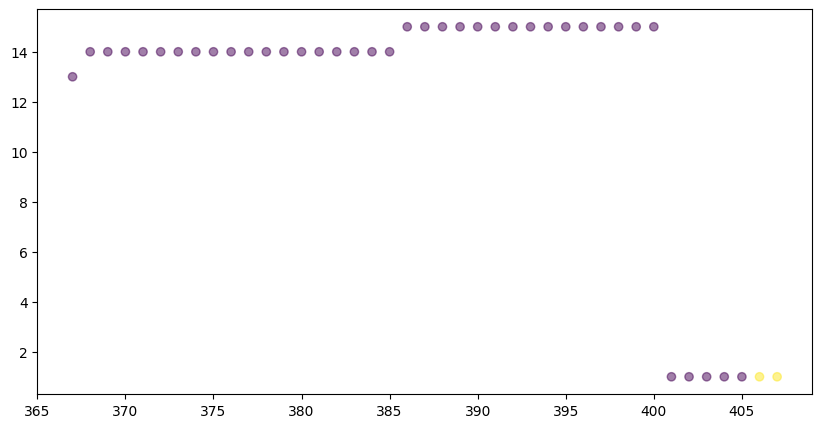

In [298]:
ob = 387
begin, end = ob-20, ob+20
plt.figure(figsize=(10,5))
plt.scatter(x=data.reset_index().loc[begin:end, ["index"]], y=data.loc[begin:end, ["Line"]], c=data.loc[begin:end, "TRIAL_INDEX"], alpha=0.5)

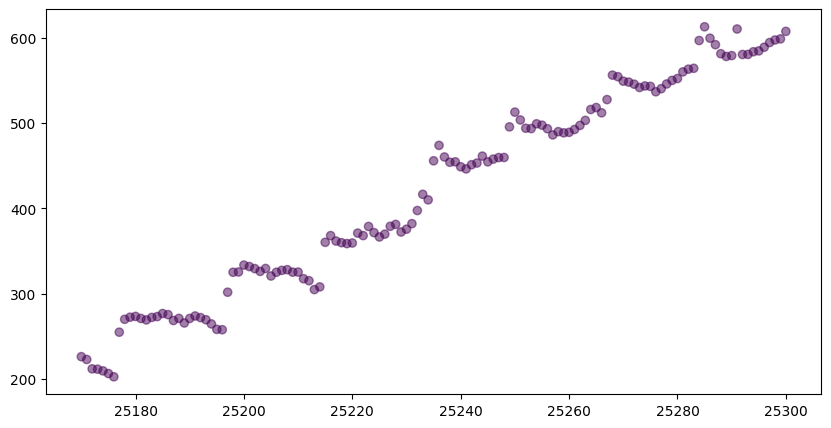

In [299]:
begin, end = 25170, 25300
plt.figure(figsize=(10,5))
plt.scatter(x=data.reset_index().loc[begin:end, ["index"]], y=data.loc[begin:end, ["CURRENT_FIX_Y"]], c=data.loc[begin:end, "TRIAL_INDEX"], alpha=0.5)

In [300]:
# DEFINE CONSTANTS
AVE_CHAR_LENGTH = 11
SCREEN_WIDTH = 1920
LINE_START = 180
LINE_END = 1740

FOVEA = 75.59 # in pixels ~ 2cm
Participants = data["File"].drop_duplicates().reset_index(drop=True)

In [301]:
def getSameLineFix(fix):
    # Find the start index
    start_mask = data.iloc[:fix.name][::-1]["Line"].ne(fix["Line"])
    start_idx = start_mask.idxmax() if start_mask.any() else fix.name

    # Find the end index
    end_mask = data[fix.name:]["Line"].ne(fix["Line"])
    end_idx = end_mask.idxmax() if end_mask.any() else fix.name


    # Adjust start_idx and end_idx while the difference is less than 20
    if end_idx - start_idx < 10:
        start_idx = max(0, start_idx - (10 - (end_idx - start_idx)))
        end_idx = min(len(data), end_idx + (10 - (end_idx - start_idx)))

    return data[start_idx:end_idx]

In [302]:
def NormalDistribute(fix, sample):    
    mask = sample.reset_index()["index"] == fix.name
    sample = stats.norm.pdf(sample, sample.mean(), sample.std())
    
    return *sample[mask], sample

In [303]:
def compareFix(fix1_idx, fix2_idx):
    fix1 = data.iloc[fix1_idx]
    fix2 = data.iloc[fix2_idx]
    
    if fix1["Line"] == fix2["Line"]:
        return fix1["CURRENT_FIX_X"] - fix2["CURRENT_FIX_X"]
    elif fix1["Line"] > fix2["Line"]:
        return fix1["CURRENT_FIX_X"] - fix2["CURRENT_FIX_X"] + (fix1["Line"] - fix2["Line"])*LINE_END
    else:
        return fix1["CURRENT_FIX_X"] - fix2["CURRENT_FIX_X"] - (fix2["Line"] - fix1["Line"])*LINE_END

In [304]:
def isFixSamePage(fix1_idx, fix2_idx):
    fix1 = data.iloc[fix1_idx]
    fix2 = data.iloc[fix2_idx]
    
    return (fix1["TRIAL_INDEX"] + fix2["TRIAL_INDEX"]) % 2 == 0

In [305]:
def Xinterval(seq):
    return [data[seq["start_fix_idx"]:seq["end_fix_idx"] + 1]["CURRENT_FIX_X"].idxmin(), 
            data[seq["start_fix_idx"]:seq["end_fix_idx"] + 1]["CURRENT_FIX_X"].idxmax()]

In [306]:
def seqList(seq):
    return data[seq["start_fix_idx"]:seq["end_fix_idx"] + 1]

In [307]:
def durationSeq(seq):
    return durationBetween(seq["start_fix_idx"], seq["end_fix_idx"])

In [308]:
def overlapSeq(seq1, seq2):
    seq1_Xinterval = Xinterval(seq1)
    seq2_Xinterval = Xinterval(seq2)
    direct = None
    
    if isFixSamePage(seq1["start_fix_idx"], seq2["start_fix_idx"]):
        if compareFix(seq1_Xinterval[0], seq2_Xinterval[0]) > 0:
            if compareFix(seq1_Xinterval[0], seq2_Xinterval[1]) > 0:
                return None
            elif compareFix(seq1_Xinterval[1], seq2_Xinterval[0]) > 0:
                direct = "Left"
            else:
                direct = "Mid"
        elif compareFix(seq1_Xinterval[1], seq2_Xinterval[0]) > 0:
            if compareFix(seq1_Xinterval[1], seq2_Xinterval[1]) > 0:
                direct = "Mid"
            else:
                direct = "Right"
        else:
            return None
    else:
        return None
    

    
    overlap_interval = list(data.loc[[seq1_Xinterval[0], seq1_Xinterval[1], seq2_Xinterval[0], seq2_Xinterval[1]], "CURRENT_FIX_X"].sort_values()[1:3])

    seq1List = seqList(seq1)["CURRENT_FIX_X"]
    seq2List = seqList(seq2)["CURRENT_FIX_X"]
    
    seq1_overlap_interval = seq1List[(seq1List >= overlap_interval[0]) & (seq1List <= overlap_interval[1])]
    seq2_overlap_interval = seq2List[(seq2List >= overlap_interval[0]) & (seq2List <= overlap_interval[1])]
    
    if seq1_overlap_interval.empty or seq2_overlap_interval.empty:
        return direct, "Overlap_noFix"
    
    
    return [direct, list(seq1_overlap_interval.iloc[[0, -1]].index), list(seq2_overlap_interval.iloc[[0, -1]].index)]

In [309]:
def numberFixBetween(fix1_idx, fix2_idx):
    return abs(fix1_idx - fix2_idx)

In [310]:
def durationBetween(fix1_idx, fix2_idx):
    return data[fix1_idx:fix2_idx]["CURRENT_FIX_DURATION"].sum()

In [311]:
def AveDurationBetween(fix1_idx, fix2_idx):
    return durationBetween(fix1_idx, fix2_idx) / numberFixBetween(fix1_idx, fix2_idx)

In [312]:
def gazeDurationBetween(fix1_idx, fix2_idx):
    return (data[fix1_idx:fix2_idx]["CURRENT_FIX_START"] - data[fix1_idx:fix2_idx]["PREVIOUS_FIX_END"] + data[fix1_idx:fix2_idx]["CURRENT_FIX_DURATION"]).sum()

In [313]:
def meanSaccadeLenBetween(fix1_idx, fix2_idx):
    return abs(data[fix1_idx:fix2_idx]["CURRENT_FIX_X"] - data[fix1_idx:fix2_idx]["PREVIOUS_FIX_X"]).mean()

In [314]:
def classifySeq(start_idx, end_idx, pre_seq):
    s = pd.Series({'start_fix_idx': start_idx, 'end_fix_idx': end_idx})
    Class, Overlap = "First Pass", None
    for pre_idx, pre_s in pre_seq[::-1].iterrows():
        overlap_seq = overlapSeq(pre_s, s)
        if overlap_seq:
            direct, *overlap_seq = overlap_seq
            Overlap = pre_idx
            if overlap_seq == ["Overlap_noFix"]:
                Class = "First Pass_noFix_" + direct
                continue
            
            if direct == "Left" or direct == "Mid":
                if numberFixBetween(overlap_seq[1][0], overlap_seq[1][1]) >= numberFixBetween(overlap_seq[0][0], overlap_seq[0][1]):
                    Class = "Second Pass/no.Fix_Left"
                elif durationBetween(overlap_seq[1][0], overlap_seq[1][1]) >= durationBetween(overlap_seq[0][0], overlap_seq[0][1]): 
                    Class = "Second Pass/duration_Left"
                elif gazeDurationBetween(overlap_seq[1][0], overlap_seq[1][1]) >= gazeDurationBetween(overlap_seq[0][0], overlap_seq[0][1]):
                    Class = "Second Pass/gazeDuration_Left"
                elif meanSaccadeLenBetween(overlap_seq[1][0], overlap_seq[1][1]) < meanSaccadeLenBetween(overlap_seq[0][0], overlap_seq[0][1]):
                    Class = "Second Pass/meanSaccade_Left"
                else:
                    Class = "First Pass_BT_Left"
            else:
                if compareFix(overlap_seq[0][0], overlap_seq[0][1]) / compareFix(Xinterval(s)[0], Xinterval(s)[1]) > 0.3:
                    Class = "Second Pass/More30%_Right"
                elif AveDurationBetween(overlap_seq[0][0], overlap_seq[0][1]) > AveDurationBetween(s["start_fix_idx"], overlap_seq[0][0]):
                    Class = "Second Pass/meanDuration_Right"
                else:
                    Class = "First Pass_BT_Right"

            if Class[:11] == "Second Pass":
                break
    return [Class, Overlap]

In [315]:
def breakSeq(start_fix, fix, prefix):
    cond = None
    if start_fix["TRIAL_INDEX"] != fix["TRIAL_INDEX"]:
        cond = "TRIAL"
    elif abs(fix["Line"] - prefix["Line"]) > 1:
        cond = "LINE DISTANCE"
    elif fix["Line"] == prefix["Line"]:
        if fix["CURRENT_FIX_X"] - fix["PREVIOUS_FIX_X"] > AVE_CHAR_LENGTH * 15:
            cond = "X SAME LINE RIGHT"
        elif fix["CURRENT_FIX_X"] - fix["PREVIOUS_FIX_X"] < - AVE_CHAR_LENGTH * 7:
            cond = "X SAME LINE LEFT"
        elif fix["CURRENT_FIX_START"] - fix["PREVIOUS_FIX_END"] > 40:
            cond = "SAC"
    else:
        if fix["PREVIOUS_FIX_X"] < LINE_END - AVE_CHAR_LENGTH * 7:
            cond = "X DIFF LINE RIGHT"
        elif fix["CURRENT_FIX_X"] > LINE_START + AVE_CHAR_LENGTH * 7:
            cond = "X DIFF LINE LEFT"
        elif fix["PREVIOUS_FIX_DURATION"] >= AveDurationBetween(start_fix.name, fix.name - 1):
            cond = "DURATION DIFF LINE"
        
    return cond

In [316]:
alpha = 0.05
prefix_idx, prefix = 0, data.iloc[0]
anomalies = []
for P in Participants:
    display(P + "... ")
    for idx, fix in data[data["File"] == P][1:].iterrows():
        if isFixSamePage(idx, prefix_idx) and fix["File"] == prefix["File"] and fix["Line"] != prefix["Line"]:
            # Get sample       
            sample_raw = getSameLineFix(fix) 
            sample = sample_raw["CURRENT_FIX_Y"] - Lines[Lines["Line"] == fix["Line"]]["Y_Start"].values

            # Transform to Normal Distribution        
            fix_normal, sample = NormalDistribute(fix, sample)

            # Compute T_Score        
            t_score = (sample.mean() - fix_normal) / (sample.std() / np.sqrt(len(sample)))
            t_alpha = stats.t.ppf(alpha, len(sample) - 1)

            if t_score > t_alpha:
                anomalies.append(idx)
                data.loc[idx, "Line"] = sample_raw["Line"].mode()[0]
                
            prefix_idx, prefix = idx, fix
display("Done")

'CBT_1... '

'CBT_10... '

'CBT_11... '

'CBT_12... '

'CBT_13... '

'CBT_14... '

'CBT_15... '

'CBT_16... '

'CBT_17... '

'CBT_18... '

'CBT_19... '

'CBT_2... '

'CBT_20... '

'CBT_21... '

'CBT_22... '

'CBT_23... '

'CBT_24... '

'CBT_25... '

'CBT_26... '

'CBT_3... '

'CBT_4... '

'CBT_5... '

'CBT_7... '

'CBT_8... '

'CB_1... '

'CB_10... '

'CB_11... '

'CB_12... '

'CB_13... '

'CB_14... '

'CB_15... '

'CB_16... '

'CB_17... '

'CB_18... '

'CB_19... '

'CB_2... '

'CB_20... '

'CB_21... '

'CB_22... '

'CB_23... '

'CB_24... '

'CB_25... '

'CB_26... '

'CB_3... '

'CB_4... '

'CB_5... '

'CB_7... '

'CB_8... '

'GMF_1... '

'GMF_10... '

'GMF_11... '

'GMF_12... '

'GMF_13... '

'GMF_14... '

'GMF_15... '

'GMF_16... '

'GMF_17... '

'GMF_18... '

'GMF_19... '

'GMF_2... '

'GMF_20... '

'GMF_21... '

'GMF_22... '

'GMF_23... '

'GMF_24... '

'GMF_25... '

'GMF_26... '

'GMF_3... '

'GMF_4... '

'GMF_5... '

'GMF_7... '

'GMF_8... '

'LSW_1... '

'LSW_10... '

'LSW_11... '

'LSW_12... '

'LSW_13... '

'LSW_14... '

'LSW_15... '

'LSW_16... '

'LSW_17... '

'LSW_18... '

'LSW_19... '

'LSW_2... '

'LSW_20... '

'LSW_21... '

'LSW_22... '

'LSW_23... '

'LSW_24... '

'LSW_25... '

'LSW_26... '

'LSW_3... '

'LSW_4... '

'LSW_5... '

'LSW_7... '

'LSW_8... '

'Done'

In [317]:
data.iloc[anomalies]

,RECORDING_SESSION_LABEL,TRIAL_INDEX,EYE_USED,CURRENT_FIX_INDEX,CURRENT_FIX_START,CURRENT_FIX_END,CURRENT_FIX_DURATION,CURRENT_FIX_X,CURRENT_FIX_X_RESOLUTION,CURRENT_FIX_Y,...,PREVIOUS_FIX_END,PREVIOUS_FIX_DURATION,PREVIOUS_FIX_X,PREVIOUS_FIX_X_RESOLUTION,PREVIOUS_FIX_Y,PREVIOUS_FIX_Y_RESOLUTION,File,Time_Spent,Text,Line
1,1,1,RIGHT,2,185,401,217,414.1,32.00,634.5,...,112,106.0,737.9,31.7,214,41.7,CBT_1,281,1,2.0
12,1,1,RIGHT,13,2806,3066,261,279.4,31.80,63.8,...,2790,142.0,301.3,31.7,73.3,41.7,CBT_1,281,1,2.0
13,1,1,RIGHT,14,3087,3210,124,331.2,31.55,76.6,...,3066,261.0,279.4,31.8,63.8,41.8,CBT_1,142,1,2.0
15,1,1,RIGHT,16,3450,3635,186,406.8,31.30,57.9,...,3428,200.0,364.0,31.45,77.4,41.55,CBT_1,210,1,2.0
18,1,1,RIGHT,19,4029,4193,165,536.6,31.20,66.5,...,3992,179.0,432.6,31.3,75.8,41.4,CBT_1,184,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1813,1,9,RIGHT,30,6683,6988,306,358.1,31.40,127.3,...,6640,128.0,532.8,31.3,270.3,41.5,CBT_1,366,1,12.0
1814,1,9,RIGHT,31,7049,7183,135,111.8,32.75,80.8,...,6988,306.0,358.1,31.4,127.3,41.5,CBT_1,166,1,12.0
1815,1,9,RIGHT,32,7215,7447,233,53.1,33.15,56.8,...,7183,135.0,111.8,32.75,80.8,42.4,CBT_1,277,1,12.0
1816,1,9,RIGHT,33,7492,7783,292,262.0,31.80,156.0,...,7447,233.0,53.1,33.15,56.8,42.7,CBT_1,1822,1,12.0


In [318]:
seq = pd.DataFrame(columns=["start_fix_idx", "end_fix_idx", "Participant", "Break_condition", "Class", "Overlap_with"])

seq_idx = 0
cond = None

start_idx, start_fix = 0, data.iloc[0]
prefix_idx, prefix, preP = 0, data.iloc[0], ''

unread = pd.DataFrame(columns=["start_fix_idx", "end_fix_idx"])
move_back = None

for P in Participants:
    display(P + "... ")
    for idx, fix in data[data["File"] == P].iterrows():
        # Divide sequences
        cond = breakSeq(start_fix, fix, prefix)
                
        if cond:
            if numberFixBetween(start_idx, prefix_idx) >= 3:
                seq.loc[seq_idx] = [start_idx, prefix_idx, preP, cond] + classifySeq(start_idx, prefix_idx, seq[seq["Participant"] == P])
                seq_idx += 1
            start_idx, start_fix = idx, fix
            cond = None

        prefix_idx, prefix, preP = idx, fix, P
        
display("Done")

'CBT_1... '

'CBT_10... '

'CBT_11... '

'CBT_12... '

'CBT_13... '

'CBT_14... '

'CBT_15... '

'CBT_16... '

'CBT_17... '

'CBT_18... '

'CBT_19... '

'CBT_2... '

'CBT_20... '

'CBT_21... '

'CBT_22... '

'CBT_23... '

'CBT_24... '

'CBT_25... '

'CBT_26... '

'CBT_3... '

'CBT_4... '

'CBT_5... '

'CBT_7... '

'CBT_8... '

'CB_1... '

'CB_10... '

'CB_11... '

'CB_12... '

'CB_13... '

'CB_14... '

'CB_15... '

'CB_16... '

'CB_17... '

'CB_18... '

'CB_19... '

'CB_2... '

'CB_20... '

'CB_21... '

'CB_22... '

'CB_23... '

'CB_24... '

'CB_25... '

'CB_26... '

'CB_3... '

'CB_4... '

'CB_5... '

'CB_7... '

'CB_8... '

'GMF_1... '

'GMF_10... '

'GMF_11... '

'GMF_12... '

'GMF_13... '

'GMF_14... '

'GMF_15... '

'GMF_16... '

'GMF_17... '

'GMF_18... '

'GMF_19... '

'GMF_2... '

'GMF_20... '

'GMF_21... '

'GMF_22... '

'GMF_23... '

'GMF_24... '

'GMF_25... '

'GMF_26... '

'GMF_3... '

'GMF_4... '

'GMF_5... '

'GMF_7... '

'GMF_8... '

'LSW_1... '

'LSW_10... '

'LSW_11... '

'LSW_12... '

'LSW_13... '

'LSW_14... '

'LSW_15... '

'LSW_16... '

'LSW_17... '

'LSW_18... '

'LSW_19... '

'LSW_2... '

'LSW_20... '

'LSW_21... '

'LSW_22... '

'LSW_23... '

'LSW_24... '

'LSW_25... '

'LSW_26... '

'LSW_3... '

'LSW_4... '

'LSW_5... '

'LSW_7... '

'LSW_8... '

'Done'

In [319]:
seq.to_excel("sequences.xlsx")

In [320]:
def getMeasurements(FP, SP, data):
    return pd.concat([
        pd.DataFrame(FP.groupby("Participant").size(), columns=["Number of First-Pass"]),
        pd.DataFrame(FP.groupby("Participant").apply(lambda seq : numberFixBetween(seq["start_fix_idx"], seq["end_fix_idx"])).groupby("Participant").sum(), columns=["Number of First-Pass Fixations"]),
        pd.DataFrame(FP.set_index("Participant").apply(durationSeq, axis=1).groupby('Participant').sum(), columns=["Duration of First-Pass Fixations"]),
        pd.DataFrame(SP.groupby("Participant").size(), columns=["Number of Second-Pass"]),
        pd.DataFrame(SP.groupby("Participant").apply(lambda seq : numberFixBetween(seq["start_fix_idx"], seq["end_fix_idx"])).groupby("Participant").sum(), columns=["Number of Second-Pass Fixations"]),
        pd.DataFrame(SP.set_index("Participant").apply(durationSeq, axis=1).groupby('Participant').sum(), columns=["Duration of Second-Pass Fixations"]),
        
        # The number of visits to each text 
        pd.DataFrame(data.groupby("File")["TRIAL_INDEX"].max().rename(None), columns=["Number of visits to each text"]),
        # The total time spent on each text 1
        pd.DataFrame(data[data["Text"] == 1].groupby("File").Time_Spent.sum().rename(None), columns=["Total time spent on text 1"]),
        # The total time spent on each text 2
        pd.DataFrame(data[data["Text"] == 2].groupby("File").Time_Spent.sum().rename(None), columns=["Total time spent on text 2"]),
        # The total time spent on each task
        pd.DataFrame((data[data["Text"] == 1].groupby("File").Time_Spent.sum() + data[data["Text"] == 2].groupby("File").Time_Spent.sum()).rename(None), columns=["Total time spent on each task"])
        # The time spent on relevant paragraphs 
        # The total time on irrelevant paragraphs 
    ], axis=1)

In [321]:
def descriptiveStatistics(measurements):
    return pd.DataFrame([
        measurements.mean().rename("Mean"),
        measurements.median().rename("Median"),
        measurements.max().rename("Max"),
        measurements.min().rename("Min"),
        measurements.skew().rename("Skew"),
        measurements.kurtosis().rename("Kurtosis")])

In [322]:
# GROUP 1 (Task CBT, Task LSW)
CBT_LSW_seq = seq[seq["Participant"].str.contains("CBT_|LSW_")]
CBT_LSW_seq_FP = CBT_LSW_seq[CBT_LSW_seq["Class"].str.contains("First Pass")]
CBT_LSW_seq_SP = CBT_LSW_seq[CBT_LSW_seq["Class"].str.contains("Second Pass")]

CBT_LSW_data = data[data["File"].str.contains("CBT_|LSW_")]

CBT_LSW_measurements = getMeasurements(CBT_LSW_seq_FP, CBT_LSW_seq_SP, CBT_LSW_data)
CBT_LSW_measurements.head()

,Number of First-Pass,Number of First-Pass Fixations,Duration of First-Pass Fixations,Number of Second-Pass,Number of Second-Pass Fixations,Duration of Second-Pass Fixations,Number of visits to each text,Total time spent on text 1,Total time spent on text 2,Total time spent on each task
CBT_1,72,415,84980,106,559,117418,9,275313,181825,457138
CBT_10,61,313,73615,38,190,42698,3,179255,119197,298452
CBT_11,37,205,43828,7,45,9918,2,65475,45224,110699
CBT_12,91,465,106231,31,178,42303,4,165050,181985,347035
CBT_13,42,242,48071,2,7,1348,2,55651,49205,104856


In [323]:
# GROUP 2 (Task GMF, Task CB)
GMF_CB_seq = seq[seq["Participant"].str.contains("GMF_|CB_")]
GMF_CB_seq_FP = GMF_CB_seq[GMF_CB_seq["Class"].str.contains("First Pass")]
GMF_CB_seq_SP = GMF_CB_seq[GMF_CB_seq["Class"].str.contains("Second Pass")]

GMF_CB_data = data[data["File"].str.contains("GMF_|CB_")]

GMF_CB_measurements = getMeasurements(GMF_CB_seq_FP, GMF_CB_seq_SP, GMF_CB_data)
GMF_CB_measurements.head()

,Number of First-Pass,Number of First-Pass Fixations,Duration of First-Pass Fixations,Number of Second-Pass,Number of Second-Pass Fixations,Duration of Second-Pass Fixations,Number of visits to each text,Total time spent on text 1,Total time spent on text 2,Total time spent on each task
CB_1,73,385,76462,81,403,85448,5,187858,171739,359597
CB_10,48,270,66420,41,214,50115,2,150898,119726,270624
CB_11,43,267,61869,8,51,11795,2,66132,58842,124974
CB_12,97,513,115622,43,182,40314,4,222119,196985,419104
CB_13,39,227,43174,11,64,14636,2,97522,51037,148559


In [324]:
# SAVE GROUP 1
with pd.ExcelWriter('CBT_LSW_measurements.xlsx') as writer:
    for col in CBT_LSW_measurements:
        CBT_LSW_measurements[[col]].to_excel(writer, sheet_name=col)
        
# SAVE GROUP 2
with pd.ExcelWriter('GMF_CB_measurements.xlsx') as writer:
    for col in GMF_CB_measurements:
        GMF_CB_measurements[[col]].to_excel(writer, sheet_name=col)

In [325]:
descriptiveStatistics(CBT_LSW_measurements)

,Number of First-Pass,Number of First-Pass Fixations,Duration of First-Pass Fixations,Number of Second-Pass,Number of Second-Pass Fixations,Duration of Second-Pass Fixations,Number of visits to each text,Total time spent on text 1,Total time spent on text 2,Total time spent on each task
Mean,52.541667,297.104167,71359.145833,35.083333,201.645833,47673.416667,3.541667,153509.854167,144304.791667,297814.645833
Median,48.000000,293.500000,70309.500000,30.500000,184.000000,42500.500000,3.000000,131866.000000,135996.500000,264225.000000
Max,91.000000,594.000000,162554.000000,106.000000,698.000000,147176.000000,10.000000,406470.000000,334264.000000,608577.000000
Min,23.000000,82.000000,21856.000000,2.000000,7.000000,1348.000000,2.000000,55651.000000,45224.000000,104856.000000
Skew,0.428295,0.225677,0.691721,0.896599,1.008888,0.898826,1.792086,1.106829,0.744071,0.608325
Kurtosis,-0.675009,-0.043563,1.061163,0.026587,0.396435,-0.030975,4.150513,1.003288,0.172845,-0.410171


In [326]:
descriptiveStatistics(GMF_CB_measurements)

,Number of First-Pass,Number of First-Pass Fixations,Duration of First-Pass Fixations,Number of Second-Pass,Number of Second-Pass Fixations,Duration of Second-Pass Fixations,Number of visits to each text,Total time spent on text 1,Total time spent on text 2,Total time spent on each task
Mean,53.041667,302.895833,72201.270833,40.458333,225.916667,53079.041667,3.729167,162891.916667,148638.020833,311529.937500
Median,50.000000,277.000000,65864.500000,32.000000,174.500000,39850.000000,3.500000,144197.000000,120068.500000,285251.000000
Max,99.000000,543.000000,153788.000000,153.000000,848.000000,201550.000000,14.000000,411504.000000,386471.000000,707214.000000
Min,22.000000,83.000000,21288.000000,1.000000,3.000000,598.000000,2.000000,64021.000000,51037.000000,124974.000000
Skew,0.750831,0.210854,0.529743,1.250187,1.307771,1.212461,2.449495,1.215621,1.068585,0.922673
Kurtosis,0.639553,-0.459229,0.483687,1.327834,1.397566,1.059815,9.132352,1.377640,0.952787,0.208361
